# Multi-label classifier

Обучите модель для предсказания аттрибутов по фотографии на датасете [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

**Задача**
Датасет содержит фотографий лиц. Каждая фотография характреризуется набором признаков: пол, возраст, улыбка ... всего 40 признаков

Нужно обучить модель которая будет предсказывать признаки по фотографии.
И оценить качество ее работы используя соответствующие метрики.



# Порядок выполнения задания

Задание рекомендуется выполнять по шагам:

1. Познакомьтесь с данными
2. Выберите метрику для оценки результата
3. Проведите анализ, изучите существующие модели которые можно использовать для решения задачи
4. Проведите EDA, опишите особенности данных и проблемы которые они могут за собой повлечь
5. Подготовьте данные для обучения
6. Выберите baseline модель, оцените качество её работы на данном датасете.
7. Попробуйте улучшить значение метрики используя другую модель. Возможно обучив/дообучив ее.
8. Оцените быстродействие выбранной модели
9. Дайте оценку полученному результату.

## Анализ данных (EDA)

# Загрузка данных

In [1]:
!wget https://ml.gan4x4.ru/hse/cv/gan_celeba.zip
!unzip gan_celeba.zip -d celeba

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: celeba/img_align_celeba/122437.jpg  
  inflating: celeba/img_align_celeba/122479.jpg  
  inflating: celeba/img_align_celeba/122609.jpg  
  inflating: celeba/img_align_celeba/122616.jpg  
  inflating: celeba/img_align_celeba/122989.jpg  
  inflating: celeba/img_align_celeba/123065.jpg  
  inflating: celeba/img_align_celeba/123927.jpg  
  inflating: celeba/img_align_celeba/125173.jpg  
  inflating: celeba/img_align_celeba/125178.jpg  
  inflating: celeba/img_align_celeba/125240.jpg  
  inflating: celeba/img_align_celeba/126281.jpg  
  inflating: celeba/img_align_celeba/126431.jpg  
  inflating: celeba/img_align_celeba/127079.jpg  
  inflating: celeba/img_align_celeba/127705.jpg  
  inflating: celeba/img_align_celeba/127743.jpg  
  inflating: celeba/img_align_celeba/127935.jpg  
  inflating: celeba/img_align_celeba/128118.jpg  
  inflating: celeba/img_align_celeba/128233.jpg  
  inflating: celeba/img_align_ce

In [ ]:
from torchvision.datasets import CelebA

# download = True cause an error with gdown
train_dataset = CelebA(root='/content', split='train', target_type='attr', download=False) #, transform=data_transform)

Total 41 attribute

In [ ]:
attr_names = train_dataset.attr_names[1:]
print("Attributes: ",", ".join(attr_names))
print(len(attr_names))

Attributes:  Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young, 
40


Look at pictures

In [ ]:
import matplotlib.pyplot as plt

# helper method
def show_images(ds, idx):
    fig, axes = plt.subplots(1, len(idx), figsize=(15, 5))
    for j, n in enumerate(idx):
        image, label = ds[n]
        axes[j].imshow(image)
        label_names = [ds.attr_names[i] for i in range(len(label)) if label[i] == 1]
        axes[j].set_title("\n".join(label_names))
        axes[j].axis('off')
    plt.show()

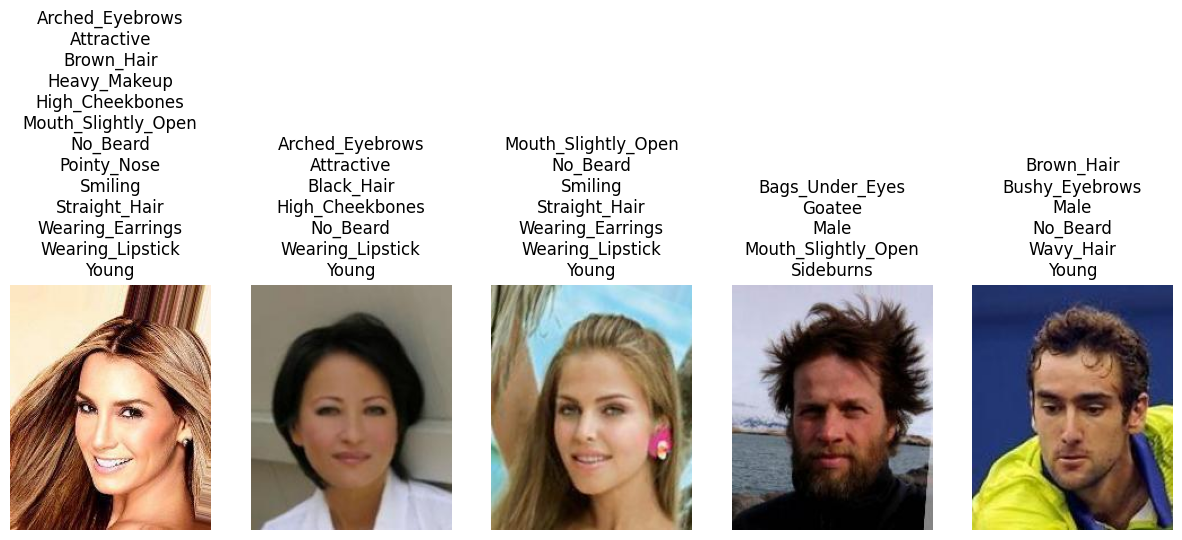

In [ ]:
show_images(train_dataset, [0,100,1000,10000,100000])

## Чтение данных

In [23]:
import pandas as pd
import os, os.path
from os import listdir
import cv2
import numpy as np
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
from PIL import Image as PILImage
from IPython.display import Image as IPImage

In [55]:
with open('/content/celeba/list_attr_celeba.txt') as f:
    lines = f.readlines()

# Получаем список классов, разделив строку по пробелам
class_labels = lines[1].strip().split()

# Формируем список атрибутов, заменяя -1 на 0
attributes = []
for line in lines[2:]:
    attribute_values = [0 if int(value) == -1 else int(value) for value in line.split()[1:]]
    attributes.append(attribute_values)

In [56]:
df = pd.DataFrame(attributes, columns=class_labels)
df.to_csv('attribute.csv', index=False)

In [57]:
attribute = pd.read_csv('attribute.csv')
attribute.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


## EDA



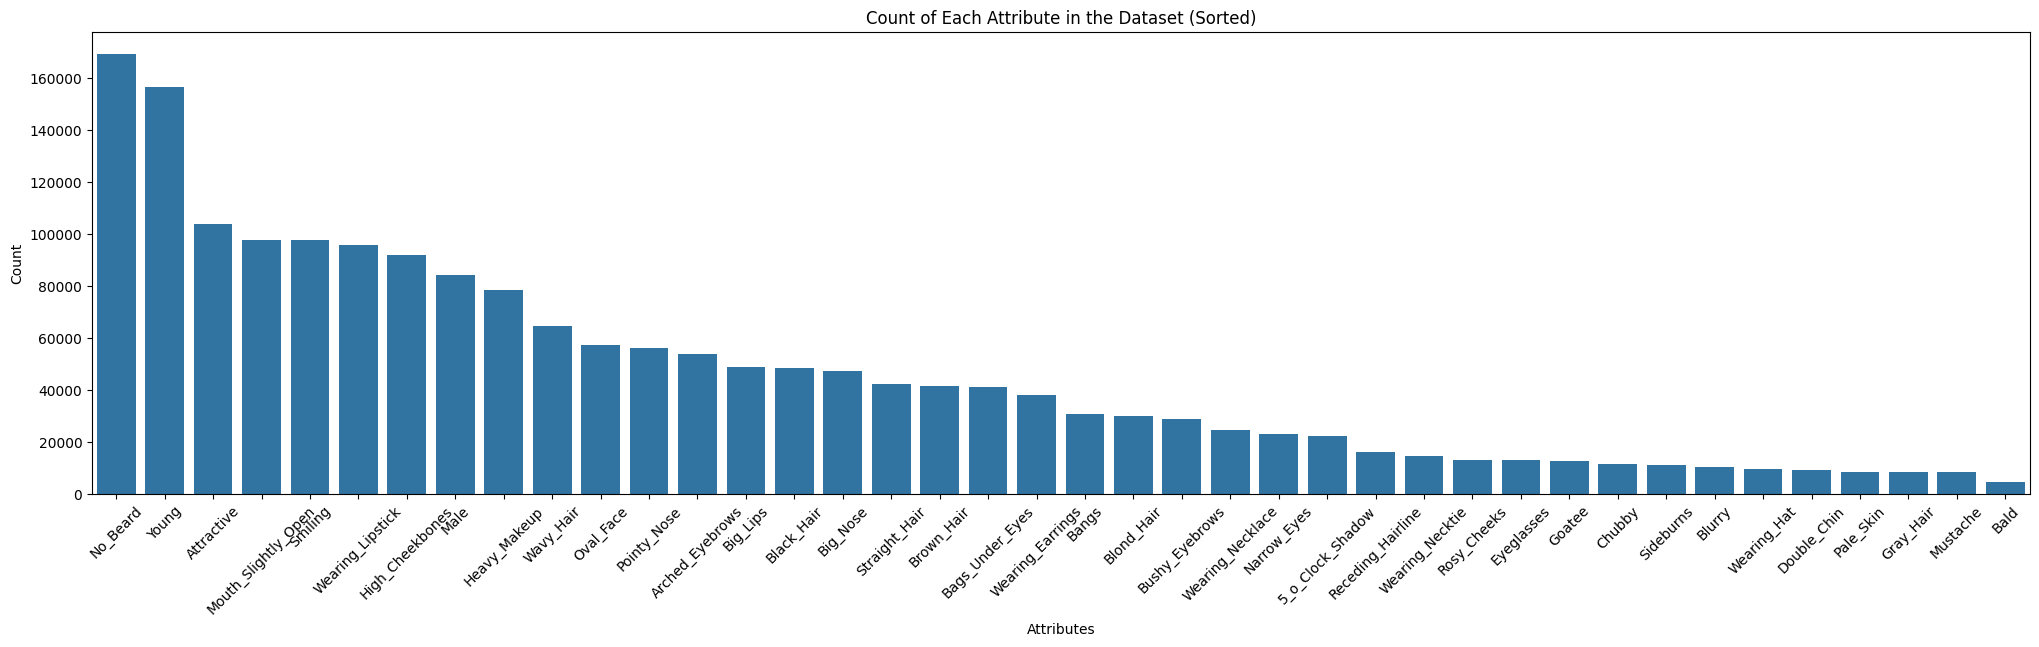

In [61]:
attribute_counts = attribute.sum()
sorted_counts = attribute_counts.sort_values(ascending=False)

# Создание графика
plt.figure(figsize=(25, 6))
sns.barplot(x=sorted_counts.index, y=sorted_counts.values)
plt.xticks(rotation=45)
plt.title('Count of Each Attribute in the Dataset (Sorted)')
plt.xlabel('Attributes')
plt.ylabel('Count')
plt.show()

Самым популярным признаком, который встречается в данных - это отсутствие бороды, а самым не популярным является признак что человек лысый. Вообще по графику частоты встречаемости каждого признака можно сделать вывод, что классы не сбалансированы. Это может привести к тому, что модель будет подстраиваться под самые популярные классы, например ей легче всего всегда говорить что на фото человек без бороды, вне зависимости от того что там на самом деле, так как в обучающих данных почти на всех фотках люди без бороды. Подгонка под популярные признаки может привести к тому, что потом на тестовых данных, где будет другой разброс частот признаках, модель будет ошибаться, давая признак "без бороды".

Второй по популярности признак - признак юнности. Можно посмотреть, сколько в данных фото с признаком "Young" и сколько нет, чтобы посмотреть есть ли тут дсильный дисбаланс и будет ли модель стремиться все фотки помечать как "Young"

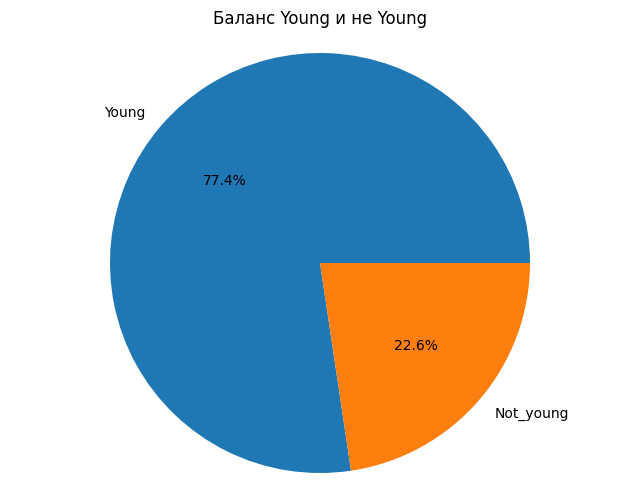

In [62]:
young_counts = attribute['Young'].sum()
not_young_counts = len(attribute) - young_counts

# Данные для диаграммы
labels = ['Young', 'Not_young']
sizes = [young_counts, not_young_counts]

# Построение круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Равные оси для круга
plt.title('Баланс Young и не Young')
plt.show()

По диаграмме наблюдается дисбаланс. Модель может склоняться к предсказанию young.

Далее по популярности признак attractive. Что-то мне подсказывает, что скорее всего attractive больше относится к женщинам. Количества женщин в датасете нет, но есть признак мужчина. Проверим сначала действительно ли есть корреляция между привлекательность и полом, а затем посмотрим на баланс тех кто привлекателен а кто нет.

In [63]:
attribute['Attractive'].corr(df['Male'], method='pearson')

-0.39445122650980763

Можно сделать вывод, что действительно скорее всего если объект имеет признак attractive то он не имеет признак male

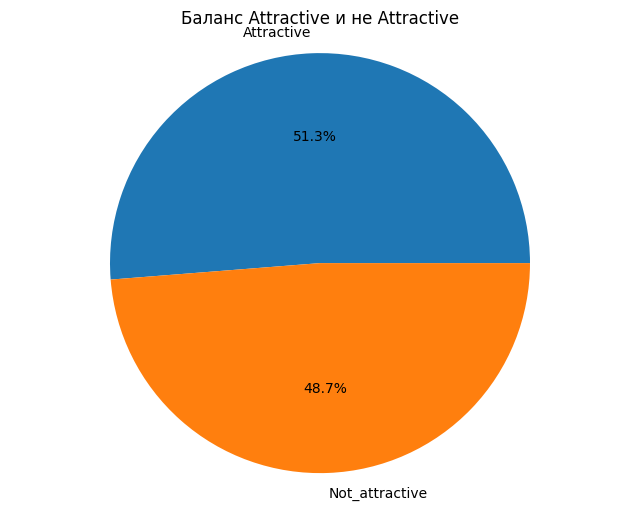

In [64]:
attractive_counts = attribute['Attractive'].sum()
not_attractive_counts = len(attribute) - attractive_counts

# Данные для диаграммы
labels = ['Attractive', 'Not_attractive']
sizes = [attractive_counts, not_attractive_counts]

# Построение круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Равные оси для круга
plt.title('Баланс Attractive и не Attractive')
plt.show()

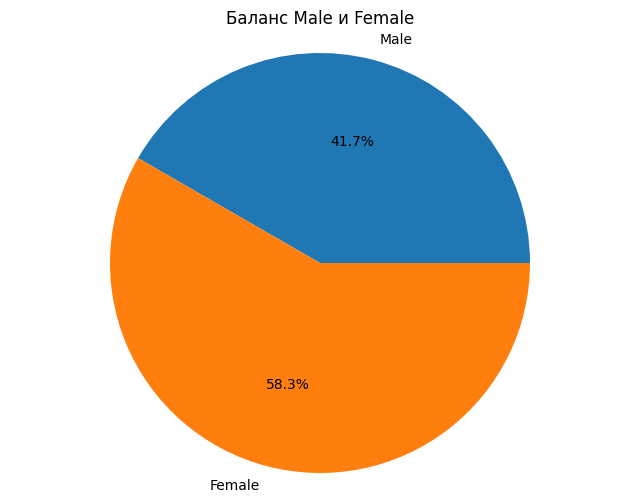

In [65]:
male_counts = attribute['Male'].sum()
not_male_counts = len(attribute) - male_counts

# Данные для диаграммы
labels = ['Male', 'Female']
sizes = [male_counts, not_male_counts]

# Построение круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Равные оси для круга
plt.title('Баланс Male и Female')
plt.show()

Количество Attractive и не Atcractive достаточно сбалансированно, что хорошо. Интересно отметить, что количество женщин и мужчин менее сбалансировано.

Посмотрим в целом как признаки коррелируют друг с другом

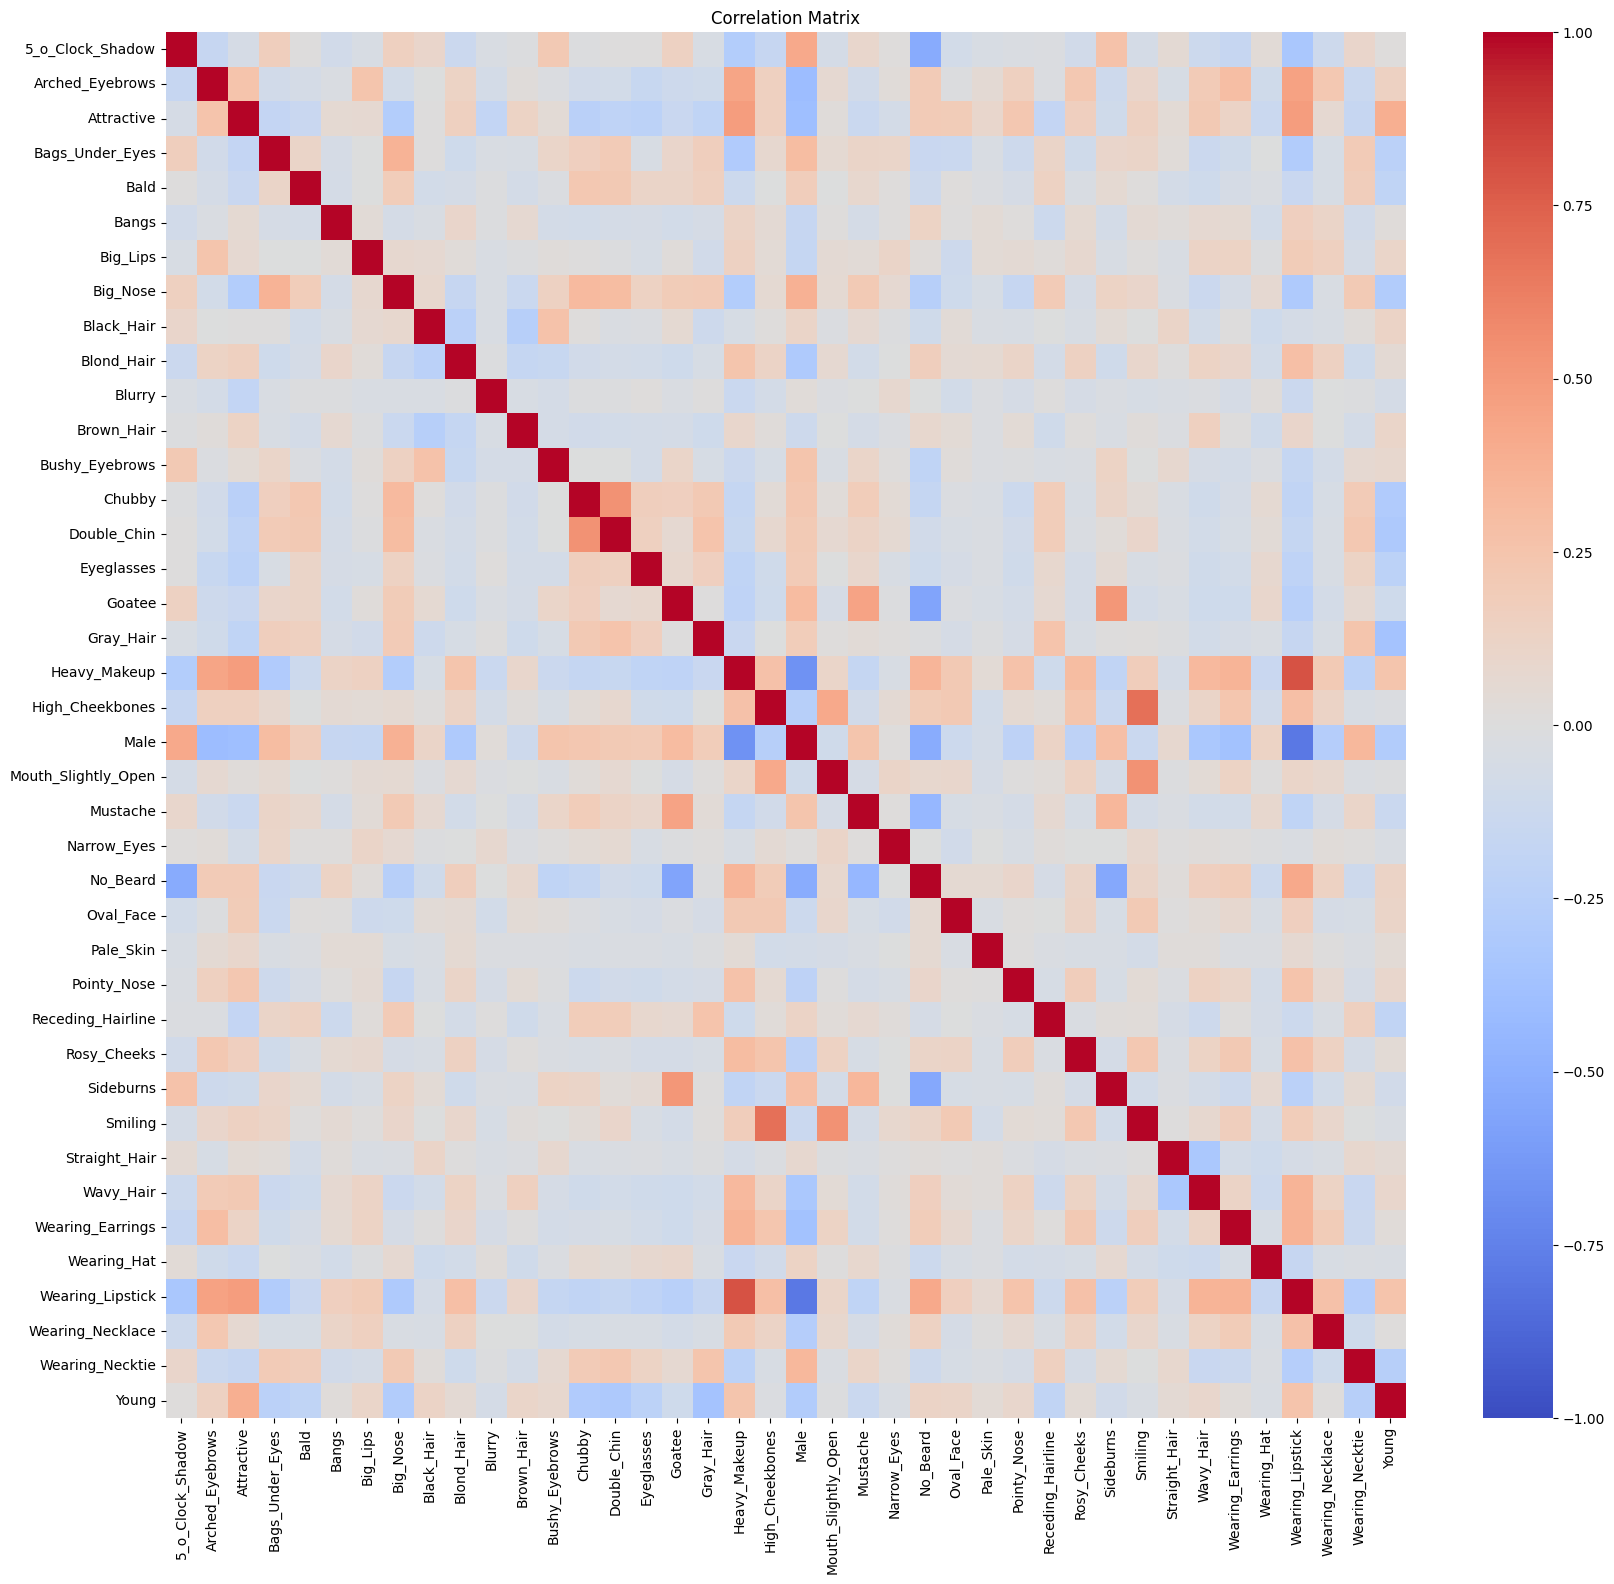

In [66]:
plt.figure(figsize=(20, 18))
sns.heatmap(attribute.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title("Correlation Matrix")
plt.show()

Видна сильная зависимость между Heavy_Makeup и Wearing_Lipstick, что в целом логично. Видна отрицательная корреляция между мужчиной и привлекательностью, которую мы посчитали ранее.

## Разделение данных

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, jaccard_score
from tqdm import tqdm
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = CelebA(root='/content', split='train', target_type='attr', transform=transform, download=False)
test_dataset = CelebA(root='/content', split='test', target_type='attr', transform=transform, download=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Метрики

Будем использовать 3 метрики: F1-score для multi-label классификации, Hamming Loss, Jaccard Index.    
  
Hamming Loss - измеряет долю неправильных меток среди всех меток. Чем ниже значение, тем лучше.
    
Jaccard Index - определяет степень совпадения между истинными и предсказанными метками.

  
Мне показались эти метрики интересными в контексте multi-label классификации

In [ ]:
# как будем считать
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, jaccard_score

# все предсказанные метки и все истинные метрики объектов
preds, labels = # evaluate(model, test_loader, device) - получаем их на тесте

# считаем метрики
f1 = f1_score(labels, preds, average='samples')  # Используем 'samples' для многоклассовой классификации
hamming = hamming_loss(labels, preds)
jaccard = jaccard_score(labels, preds, average='samples')

## Baseline

Начнем с модели resnet18. Затем попробуем протестировать другие модели и вычислить из них самую лучшую

In [43]:
model = models.resnet18(pretrained=True)

num_classes = len(train_dataset.attr_names) - 1  # Количество атрибутов
model.fc = nn.Linear(model.fc.in_features, num_classes) # Меняем выход модели под multi-label классификацию

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 15.1MB/s]


## Решение

In [44]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Training", leave=False):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Test", leave=False):
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Применяем сигмоиду и порог 0.5

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return all_preds, all_labels

### Запуск resnet18

In [45]:
num_epochs = 5
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, device)

preds, labels = evaluate(model, test_loader, device)

In [46]:
# Рассчет метрик
preds = np.vstack(preds)
labels = np.vstack(labels)

f1 = f1_score(labels, preds, average='samples')  # Используем 'samples' для многоклассовой классификации
hamming = hamming_loss(labels, preds)
jaccard = jaccard_score(labels, preds, average='samples')

print(f"F1 Score: {f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")

F1 Score: 0.7175
Hamming Loss: 0.1070
Jaccard Index: 0.5777


### Запуск vgg16

In [4]:
model = models.vgg16(pretrained=True)

num_classes = len(train_dataset.attr_names) - 1  # Количество атрибутов
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes) # Меняем выход модели под multi-label классификацию

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.0MB/s]


In [8]:
%%time
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

num_epochs = 5
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, device)

# Оценка модели
preds, labels = evaluate(model, test_loader, device)

CPU times: user 1h 4min 57s, sys: 44.7 s, total: 1h 5min 41s
Wall time: 1h 6min 28s


In [9]:
preds = np.vstack(preds)
labels = np.vstack(labels)

f1 = f1_score(labels, preds, average='samples')
hamming = hamming_loss(labels, preds)
jaccard = jaccard_score(labels, preds, average='samples')

print(f"F1 Score: {f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")

F1 Score: 0.7437
Hamming Loss: 0.0993
Jaccard Index: 0.6103


### Запуск efficientnet_b0

In [10]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Обновляем последний слой

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 150MB/s]


In [11]:
%%time
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

num_epochs = 5
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, device)

preds, labels = evaluate(model, test_loader, device)

CPU times: user 26min 33s, sys: 39.5 s, total: 27min 12s
Wall time: 27min 45s


In [12]:
preds = np.vstack(preds)
labels = np.vstack(labels)

f1 = f1_score(labels, preds, average='samples')
hamming = hamming_loss(labels, preds)
jaccard = jaccard_score(labels, preds, average='samples')

print(f"F1 Score: {f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")

F1 Score: 0.7856
Hamming Loss: 0.0860
Jaccard Index: 0.6636


### Запуск densenet121

In [13]:
from torchvision.models import densenet121

model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)  # Обновляем последний слой

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 120MB/s]


In [14]:
%%time
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

num_epochs = 5
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, device)

preds, labels = evaluate(model, test_loader, device)

CPU times: user 40min 12s, sys: 3min, total: 43min 13s
Wall time: 43min 59s


In [15]:
preds = np.vstack(preds)
labels = np.vstack(labels)

f1 = f1_score(labels, preds, average='samples')
hamming = hamming_loss(labels, preds)
jaccard = jaccard_score(labels, preds, average='samples')

print(f"F1 Score: {f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")

F1 Score: 0.7717
Hamming Loss: 0.0929
Jaccard Index: 0.6455


### Запуск mobilenet_v2

In [16]:
from torchvision.models import mobilenet_v2

model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Обновляем последний слой

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 212MB/s]


In [17]:
%%time
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

num_epochs = 5
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, device)

preds, labels = evaluate(model, test_loader, device)

CPU times: user 23min 58s, sys: 37.9 s, total: 24min 36s
Wall time: 25min 16s


In [18]:
preds = np.vstack(preds)
labels = np.vstack(labels)

f1 = f1_score(labels, preds, average='samples')
hamming = hamming_loss(labels, preds)
jaccard = jaccard_score(labels, preds, average='samples')

print(f"F1 Score: {f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")

F1 Score: 0.7816
Hamming Loss: 0.0869
Jaccard Index: 0.6582


## Оценка результата

По результатам было протестировано 5 архитектр моделей на 5 эпохах:  
*   **resnet18**  
    Время обучения: 23min 40s    
    F1 Score: 0.7175  
    Hamming Loss: 0.1070  
    Jaccard Index: 0.5777
*   **vgg16**  
    Время обучения: 1h 6min 28s  
    F1 Score: 0.7437  
    Hamming Loss: 0.0993  
    Jaccard Index: 0.6103
*   **efficientnet_b0**  
    Время обучения: 27min 45s  
    F1 Score: 0.7856  
    Hamming Loss: 0.0860  
    Jaccard Index: 0.6636  
*   **densenet121**  
    Время обучения: 43min 59s  
    F1 Score: 0.7717  
    Hamming Loss: 0.0929  
    Jaccard Index: 0.6455  
*   **mobilenet_v2**  
    Время обучения: 25min 16s   
    F1 Score: 0.7816  
    Hamming Loss: 0.0869  
    Jaccard Index: 0.6582

Самая лучшая модель - **efficientnet_b0**. Если судить по ее метрикам - Hamming Loss = 0.0860 говорит о том, что модель почти отличная, но по Jaccard Index = 0.6636 и F1 Score = 0.7856 я скорее скажу что модель хорошая, но не вау. В целом, это хороший результат если брать во внимание количество обучаемых весов (меньше чем в других моделях) и соответсвенно количество времени, которое тратися на обучение (приемлемое).